In [1]:
import numpy as np
import pandas as pd
import operator
import random
from scipy import stats
import matplotlib.pyplot as plt
import MLE_classifier as mle

In [2]:
train = pd.read_csv('hw1data/propublicaTrain.csv')
test = pd.read_csv('hw1data/propublicaTest.csv')

# 5.4.3 Naive Bayes

In [3]:
# Preprocessing
def preprocess(df):
    '''Remove c_charge_degree_M column due to redunduncy'''
    return df.drop(labels=['c_charge_degree_M'], axis=1)

In [4]:
def naive_bayes_train(df, features, target='two_year_recid', k=1):
    """returns class conditional probability distribution and class prior as dictionaries"""
    # initialize variables
    sample_size, feature_dim = df.shape[0], len(features)
    # print('sample_size, feature_dim: ', sample_size, feature_dim)
    y_count = {} # {key = label : value = count of label in sample},
    x_count = {} # dict of dicts of dicts = {key=label:value={key=feature:value={key=feature_val:value=count}}}
    feature_given_class = {} # Pr[X=x|Y=y]
    class_prior = {} # Pr[Y=y]
    
    # initialize dictionary keys
    for label in df[target].unique():
        y_count[label], class_prior[label] = 0, 0
        x_count[label], feature_given_class[label] = {}, {}
        for feature in features:
            x_count[label][feature], feature_given_class[label][feature] = {}, {}
    
    # print('y_count: ', y_count)
    # print('x_count: ', x_count)
    
    # update dictionary values
    for index, row in df.iterrows():
        label = row[target]
        y_count[label] += 1
        for feature in features:
            feature_val = row[feature]
            if feature_val in x_count[label][feature].keys():
                x_count[label][feature][feature_val] += 1
            else:
                x_count[label][feature][feature_val] = 1
    
    # print('y_count: ', y_count)
    # print('x_count: ', x_count)
    
    # find class prior probabilities
    for label in class_prior.keys():
        class_prior[label] = y_count[label]/sample_size
    
    # find feature given class probabilities with additive smoothing
    for label in feature_given_class.keys():
        for feature in feature_given_class[label].keys():
            for feature_val in x_count[label][feature].keys():
                feature_given_class[label][feature][feature_val] = \
                (x_count[label][feature][feature_val] + k) / (y_count[label] + k * feature_dim)
    # print('class prior: ', class_prior)
    # print('f|c: ', feature_given_class)
    return class_prior, feature_given_class, y_count

In [5]:
def predict(series, features, class_prior, feature_given_class, y_count, k=1):
    """given a series, return a belief distribution over possible labels"""
    belief = {}
    for label in class_prior.keys():
        prob = class_prior[label]
        for feature in features:
            feature_val = series[feature]
            # print(feature, feature_val)
            if feature_val in feature_given_class[label][feature]:
                prob *= feature_given_class[label][feature][feature_val]
            else:
                prob *= k/(y_count[label] + k * len(features))
        belief[label] = prob
    return belief

In [6]:
def evaluate(df, features, class_prior, feature_given_class, y_count, target = 'two_year_recid'):
    total_pred, accurate_pred = 0, 0
    y_preds = []
    for index, row in df.iterrows():
        y = row[target]
        belief = predict(row, features, class_prior, feature_given_class, y_count)
        y_pred = max(belief.items(), key=operator.itemgetter(1))[0]
        total_pred += 1
        if y_pred == y:
            accurate_pred += 1
        y_preds.append(y_pred)
    y_pred_df = pd.DataFrame({'prediction': y_preds})
    df = pd.concat([df, y_pred_df], axis=1)
    accuracy = accurate_pred/total_pred
    return accuracy, df

In [7]:
def perform_naive_bayes(train, test):
    train = preprocess(train)
    test = preprocess(test)
    features = list(train)[1:]
    class_prior, feature_given_class, y_count = naive_bayes_train(train, features)
    return evaluate(test, features, class_prior, feature_given_class, y_count)

# K-NN

In [8]:
#Normed Distance
def distance(x,y,p):
    if (p=='inf'):
        all_dist = np.zeros(np.shape(x)[0])
        for i in range(np.shape(x)[0]):
            all_dist[i] = abs(x[i]-y[i])
        return np.amax(all_dist)
    else:
        sum = 0
        for i in range(np.shape(x)[0]):
            sum += (abs(x[i]-y[i]))**p
        return sum**(1/p)


In [9]:
def perform_knn(train, test):
    #Training-Validation Split
    raw_train_labels=np.array(train['two_year_recid'])
    raw_train_input = np.array([np.array(train['sex']),np.array(train['age']),
                                np.array(train['race']),np.array(train['juv_fel_count']),
                                np.array(train['juv_misd_count']),np.array(train['juv_other_count']),
                                np.array(train['priors_count']),np.array(train['c_charge_degree_F'])])
    validation_pct = 20
    val_size = validation_pct*len(raw_train_labels)//100
    val_ind = random.sample(range(len(raw_train_labels)), val_size)
    validation_input = np.zeros((8,val_size))
    validation_labels = np.zeros(val_size)
    training_input = np.zeros((8,len(raw_train_labels)-val_size))
    training_labels = np.zeros(len(raw_train_labels)-val_size)
    cat_names = ['sex','age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','c_charge_degree_F']
    val_cnt = 0
    trn_cnt = 0
    for i in range(len(raw_train_labels)):
        if i in val_ind:
            for j in range(len(cat_names)):
                validation_input[j,val_cnt]=train[cat_names[j]].iloc[i]
            validation_labels[val_cnt]=train['two_year_recid'].iloc[i]
            val_cnt += 1
        else:
            for j in range(len(cat_names)):
                training_input[j,trn_cnt]=train[cat_names[j]].iloc[i]
            training_labels[trn_cnt]=train['two_year_recid'].iloc[i]
            trn_cnt += 1
    
    #Reading in Test Data
    test_labels = np.array(test['two_year_recid'])
    test_input = np.array([np.array(test['sex']),np.array(test['age']),np.array(test['race']),
                           np.array(test['juv_fel_count']),np.array(test['juv_misd_count']),
                           np.array(test['juv_other_count']),np.array(test['priors_count']),
                           np.array(test['c_charge_degree_F'])])
    
    #Running the best model, based on validation data, on our testing data
    k_final=15
    p_final=1
    pred_test_labels = np.zeros(len(test_labels))
    for i in range(len(test_labels)):
        all_distances = np.zeros(len(training_labels))
        for j in range(len(training_labels)):
            all_distances[j]=distance(test_input[:,i],training_input[:,j],p_final)
        ind = np.argpartition(all_distances,k_final)[:k_final]
        nearest_labels = [training_labels[temp] for temp in ind]
        pred_test_labels[i] = stats.mode(nearest_labels, axis=None)[0][0]
    num_correct = 0
    for ent in range(len(test_labels)):
        if (test_labels[ent]==pred_test_labels[ent]):
            num_correct += 1
    ACCURACY = num_correct/len(test_labels)
    TEST_PRED_LIST = pred_test_labels
    
    # clean up and return
    predictions = pd.DataFrame({'prediction': TEST_PRED_LIST})
    df = pd.concat([test, predictions], axis=1)
    return ACCURACY, df

# 5.5 Which classifier is better for this prediction task?

In [10]:
# define numbers of training samples we are interested in
training_samples_nums = [100,200]
l = [463*i for i in range(1,10)]
training_samples_nums = training_samples_nums + l
training_samples_nums

[100, 200, 463, 926, 1389, 1852, 2315, 2778, 3241, 3704, 4167]

In [11]:
# knn_nums = [100, 200, 463, 926, 1389, 1852, 2315, 2778, 3241, 3334]

In [12]:
bayes_accuracies = []
mle_accuracies = []
knn_accuracies = []

In [16]:
# find accuracies of classifiers
for number in training_samples_nums:
    print(number)
    new_train = train.sample(number)
    mle_accuracy, _ = mle.perform_mle(new_train, test)
    mle_accuracies.append(mle_accuracy)

100
200
463
926
1389
1852
2315
2778
3241
3704
4167


In [17]:
len(mle_accuracies)

11

In [18]:
for number in training_samples_nums:
    print(number)
    new_train = train.sample(number)
    bayes_accuracy, _ = perform_naive_bayes(new_train, test)
    bayes_accuracies.append(bayes_accuracy)

100
200
463
926
1389
1852
2315
2778
3241
3704
4167


In [19]:
for number in training_samples_nums:
    print(number)
    new_train = train.sample(number)
    print(len(new_train))
    knn_accuracy, _ = perform_knn(new_train, test)
    knn_accuracies.append(knn_accuracy)

100
100
200
200
463
463
926
926
1389
1389
1852
1852
2315
2315
2778
2778
3241
3241
3704
3704
4167
4167


In [20]:
len(knn_accuracies)

11

In [21]:
knn_accuracies

[0.607,
 0.657,
 0.651,
 0.6665,
 0.6735,
 0.673,
 0.674,
 0.6655,
 0.6675,
 0.6625,
 0.672]

In [22]:
mle_accuracies

[0.6605,
 0.6155,
 0.6225,
 0.6285,
 0.638,
 0.6325,
 0.6405,
 0.6385,
 0.6375,
 0.6345,
 0.633]

In [23]:
bayes_accuracies

[0.6405,
 0.606,
 0.657,
 0.6595,
 0.6775,
 0.671,
 0.683,
 0.6765,
 0.6785,
 0.687,
 0.6875]

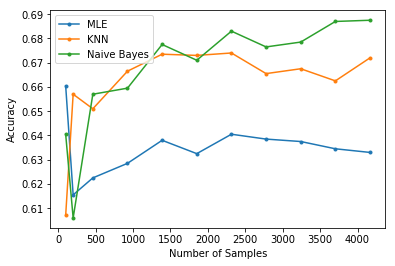

In [25]:
plt.plot(training_samples_nums, mle_accuracies,'.-', label='MLE')
plt.plot(training_samples_nums, knn_accuracies,'.-', label='KNN')
plt.plot(training_samples_nums, bayes_accuracies,'.-', label='Naive Bayes')
plt.ylabel('Accuracy')
plt.xlabel('Number of Samples')
plt.legend(loc='upper left')
plt.show()
